In [4]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import pandas as pd
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [ ]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims,skipna=True)

def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(55,75))
    ak_slice = lat_slice.sel(lon=slice(192,225))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims,skipna=True)

def ne_america_mean(ds):
    lat_slice = ds.sel(lat=slice(30,45))
    ak_slice = lat_slice.sel(lon=slice(268,288))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims,skipna=True)

def arctic_mean(ds):
    lat_slice = ds.sel(lat=slice(60,90))
    lat = lat_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(lat_slice.dims) - {'time'}
    return (lat_slice * weight).mean(other_dims,skipna=True)

In [ ]:
def load_all_models(model_name):
    tas_anomaly_hist = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_historical.nc')
    #tas_anomaly_ssp126 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp126.nc')
    tas_anomaly_ssp245 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp245.nc')
    #tas_anomaly_ssp370 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp370.nc')
    tas_anomaly_ssp585 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp585.nc')
    tas_anomalies = [tas_anomaly_hist,tas_anomaly_ssp245,tas_anomaly_ssp585]
    return tas_anomalies

In [ ]:
def calc_anomalies(source_ids):
    """
    Calculates the surface temperature anomalies for various regions, returns a list of datasets
    each dataset is for 1 scenario and contains the mean temperature anomaly for 4 regions for each model source
    source_ids: a list of strings of source_ids ('ACCESS_CM2', etc)
    for 
    """
    
    regions = ['global','alaska','arctic','ne_america']
    datas = []
    for s_id in source_ids:
        datas.append(load_all_models(s_id))
        #load_all_models returns a list of datasets for each of the 3 models
        #order of models: 'historical' , 'ssp245' , 'ssp585'
    #datas is now a list of lists, one list of datsets for each source_id
    models_list = []
    for m in range(3):
        #for each scenario (hist, ssp245, etc) we create a dataset with regional means 
        source_dict = {}
        for s in range(len(source_ids)):
            model_ds = xr.Dataset(coords=dict(time=datas[s][m]['time']))
            model_ds['global_mean']=global_mean(datas[s][m])['tas']
            model_ds['alaska_mean']=alaska_mean(datas[s][m])['tas']
            model_ds['arctic_mean']=arctic_mean(datas[s][m])['tas']
            model_ds['ne_america_mean']=ne_america_mean(datas[s][m])['tas']
            source_dict[source_ids[s]]=model_ds
        models_list.append(source_dict)
    
    #we return a list of datasets, one for each scenario.
    return models_list
            
def edit_leap_years(dataset):
    """
    dataset should already have a dayofyear attribute
    determines which years are leap years and edits the dayofyear coordinate to go 1-365,
    rather than 1-366 and skipping 60
    """
    years = np.arange(1840,2350)
    leapyears = years[years%4==0]
    leapyears = leapyears[leapyears!=1900]
    leapyears = leapyears[leapyears!=2100]
    leapyears = leapyears[leapyears!=2200]
    leapyears = leapyears[leapyears!=2300]
    for d in range(dataset['dayofyear'].shape[0]):
        if dataset['dayofyear'][d]>60:
            if int(dataset['time.year'][d]) in leapyears:
                dataset['dayofyear'][d] -= 1
            #isleapyear = (dataset['time.year'][d]% 4 == 0) and (dataset['time.year'][d] != 1900)and (dataset['time.year'][d] != 2100)
        #if d%350 == 0:
            #print(cm2['time.year'][d]['time.year'], isleapyear)
        #if isleapyear and dataset['dayofyear'][d]>60:
            #dataset['dayofyear'][d] -= 1
    
    uniquedays_after = 0
    for d,data in dataset.groupby('dayofyear'):
        uniquedays_after +=1
    print(uniquedays_after)
    assert uniquedays_after == 365
    
    return dataset         

In [ ]:
source_id_list = ['ACCESS-CM2','ACCESS-ESM1-5','NorESM2-LM','NorESM2-MM','CanESM5','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
models_list = calc_anomalies(source_id_list[2:])

In [ ]:
load_in = load_all_models('ACCESS-CM2')
load_in[2]

In [ ]:
models = ['historical','ssp245','ssp585']
for m in range(2,3):
    for s in source_id_list[2:]:
        print('editing leap years for ', models[m],s)
        noleapdata = edit_leap_years(models_list[m][s])
        delayed_obj = noleapdata.to_netcdf(path='/nobackup/users/lulur/region_mean_files/'+s+'_'+models[m]+'_noleap.nc', mode='w', compute=False, engine='netcdf4', format='NETCDF4')
        print('writing data to region_mean_files/'+s+'_'+models[m]+'_noleap.nc')

        with progress.ProgressBar():
            results = delayed_obj.compute()
            #print(s,models_list[2][s])

In [ ]:
cm2 = xr.open_dataset('/nobackup/users/lulur/region_mean_files/ACCESS-CM2_ssp245.nc')
uniquedays_before = 0
for d,data in cm2.groupby('dayofyear'):
    uniquedays_before +=1
print(uniquedays_before)
def edit_leap_years(dataset):
    """
    dataset should already have a dayofyear attribute
    determines which years are leap years and edits the dayofyear coordinate to go 1-365,
    rather than 1-366 and skipping 60
    """
    years = np.arange(1850,2101)
    leapyears = years[years%4==0]
    leapyears = leapyears[leapyears!=1900]
    leapyears = leapyears[leapyears!=2100]
    print(leapyears)
    for d in range(dataset['dayofyear'].shape[0]):
        if dataset['dayofyear'][d]>60:
            if int(dataset['time.year'][d]) in leapyears:
                dataset['dayofyear'][d] -= 1
            #isleapyear = (dataset['time.year'][d]% 4 == 0) and (dataset['time.year'][d] != 1900)and (dataset['time.year'][d] != 2100)
        #if d%350 == 0:
            #print(cm2['time.year'][d]['time.year'], isleapyear)
        #if isleapyear and dataset['dayofyear'][d]>60:
            #dataset['dayofyear'][d] -= 1
    
    uniquedays_after = 0
    for d,data in dataset.groupby('dayofyear'):
        uniquedays_after +=1
    print(uniquedays_after)
    assert uniquedays_after == 365
    
    return dataset 

# def edit_leap_years(dataset):
#     """
#     dataset should already have a dayofyear attribute
#     determines which years are leap years and edits the dayofyear coordinate to go 1-365,
#     rather than 1-366 and skipping 60
#     """
#     for d, ddata in dataset.groupby('time.dayofyear'):
#         if d>60:
#             years = np.asarray(ddata['time.year'],dtype=int)
#             #print(years)
#             #print('True leap years',np.sum(years% 4 == 0))
#             isleapyear = np.logical_and((years% 4 == 0),(years != 1900))
#             with_exceptions = np.logical_and((years != 2100),isleapyear)
#             #print('True leap years',np.sum(with_exceptions))#if d%350 == 0:
#                 #print(cm2['time.year'][d]['time.year'], isleapyear)
#             days = np.asarray(ddata['dayofyear'],dtype=int)
#             #print(type(days[0]),type(with_exceptions[0]),days.shape,with_exceptions.shape)
#             days[with_exceptions] = d-1
#             ddata['dayofyear'] = days

#     uniquedays_after = 0
#     for d,data in dataset.groupby('dayofyear'):
#         uniquedays_after +=1
#     print(uniquedays_after)
#     #assert uniquedays_after == 365
    
#     return dataset

new_cm2 = edit_leap_years(cm2)
new_cm2['dayofyear'].where(new_cm2['dayofyear']==366,drop=True).shape

# ANALYZE ANOMALY DATA

In [ ]:
dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/ACCESS-CM2_historical_noleap.nc')
dataset1, linregressions = remove_trend(dataset)
dataset1

In [ ]:
for i in range(4):
    days = np.arange(dataset['time'].shape[0])
    line = linregressions[i].slope*days + linregressions[i].intercept
    slope = round(linregressions[i].slope*365,2)
    plt.figure(figsize=(8,6))
    plt.plot(dataset['time'],line,'r-',label='slope='+str(slope)+'ºC/year')
#plt.plot(days,gmsts['anomalies'],'b-',alpha=0.5)
    plt.title(regions[i]+' Mean Temperature Anomalies With Trend Subtracted')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly in ºC, after subtracting trend')
    plt.plot(dataset['time'],dataset[regions[i]+'_mean'],alpha=0.7)
    #plt.savefig('./figures/NCEP_NCAR_anomalies/trends/'+regions[i]+'_notrend.png')

In [ ]:
# for s in source_id_list:
#     stdevs = find_std_mean(s)
#     for r in regions:
#         plt.figure(figsize=(8,6))
#         plt.plot(stdevs['dayofyear'],stdevs[r+'_mean'],label='from raw data')
#         plt.plot(stdevs['dayofyear'],stdevs[r+'_no_trend'],label='with trend removed')
#         plt.title(r+' Standard Deviation Climatology, '+s)
#         plt.legend()
#         plt.ylabel('Degrees Celsius')
#         plt.xlabel('Day of Year')
#         plt.savefig('./figures/models_stdev_plots/compare_no_trend_stds/std_climatology_'+s+'_' + r+'.png')
#         plt.show()

In [8]:
#calculate the mean and standard deviation of surface temperatures for each region over the historical period
def find_std_mean(source_id):
    dataset = xr.open_dataset('../region_mean_files/'+source_id+'_historical_noleap.nc')
    #dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/'+source_id+'_historical_noleap.nc')
    slice_mst = dataset.sel(time=slice('1981-01-01', '2020-12-31'))
    slice_mst, linregressions = remove_trend(slice_mst)
    means = []
    stds = []
    days = []
    for doy, doydata in slice_mst.groupby('dayofyear'):
        #for day, data in mdata.groupby('time.day'):
        meantemp = doydata.mean('time')
        stdtemp = doydata.std('time')
        means.append(meantemp)
        days.append(doy)
        stdtemp['dayofyear']=doy
        stds.append(stdtemp)
    #means.append(region_means)
    #stds.append(region_stds)
    #print(days)
    stds_concat = xr.concat(stds,'dayofyear')
    return stds_concat
        

In [43]:
models = ['historical','ssp245','ssp585']
source_id_list = ['ACCESS-CM2','ACCESS-ESM1-5','NorESM2-LM','NorESM2-MM','CanESM5','MPI-ESM1-2-HR','MPI-ESM1-2-LR']

source_std_dict = {}
for s in range(len(source_id_list)):
    source_std_dict[source_id_list[s]]= find_std_mean(source_id_list[s])

scenarios_dict = {}
for m in models:
    source_dict = {}
    for s in source_id_list:
        dataset = xr.open_dataset('../region_mean_files/'+s+'_'+m+'_noleap.nc')
        #dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/'+s+'_'+m+'_noleap.nc')
        source_dict[s] = dataset
    scenarios_dict[m]= source_dict

/opt/anaconda3/envs/cicoes37/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/cicoes37/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [ ]:
newdata, linregress = remove_trend(scenarios_dict['historical']['ACCESS-CM2'])
newdata
#source_std_dict['ACCESS-CM2']

In [ ]:
for s in source_id_list:
    dataset = scenarios_dict['historical'][s]
    dataset = dataset.sel(time=slice('1981-01-01', '2020-12-31'))
    days = np.arange(dataset['time'].shape[0])
    #line = linregressions[i].slope*days + linregressions[i].intercept
    #slope = round(linregressions[i].slope*365,2)
    plt.figure(figsize=(8,6))
    plt.plot(dataset['time'],dataset['global_mean'],alpha=0.7)
    #plt.plot(dataset['time'],line,'r-',label='slope='+str(slope)+'ºC/year')
    plt.title('Global Mean Temperature Anomalies Over Time')
    #plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly in ºC, after subtracting trend')
    
    #plt.savefig('./figures/NCEP_NCAR_anomalies/trends/'+regions[i]+'_notrend.png')

In [ ]:
# for r in regions:
#     plt.figure(figsize=(10,8))
#     sum_stdevs = np.zeros((365))
#     for s in source_id_list:
#         stdev = source_std_dict[s]
#         sum_stdevs += stdev[r+'_n']
#         #timeslice = data_arrs[i].sel(time=slice('1989-01-01', '1995-12-31'))
#         #timeslice = np.asarray(histdata['time'])
#         #time = [i[0].dayofyear for i in data_arrs[i]['time']]
#         plt.plot(np.arange(1,366),stdev[r+'_mean'],color='tab:blue',alpha=0.3)
#         #plt.plot(clims[i]['time'].dt.dayofyear,clims[i],label = regions[i]+' climatology mean')
#         #plt.xlim(1990,2000)

#     sum_stdevs /= len(source_id_list)
#     plt.plot(np.arange(1,366),sum_stdevs,color='tab:red',label='Mean of 7 models')
#     plt.legend()
#     plt.title(r+' Standard Deviation in Surface Temperature by Day of Year')
#     plt.xlabel('Day Of The Year')
#     plt.ylabel(r+' standard deviation in surface temperature')
#     plt.savefig('./figures/models_stdev_plots/std_climatology_allmodels_' + r+'.png')

In [5]:
regions = ['global','alaska','arctic','ne_america']
def remove_trend(dataset):
    days = np.arange(dataset['time'].shape[0])
    linregressions = []
    for r in regions:
        linregress = stats.linregress(days,dataset[r+'_mean'])
        line = linregress.slope*days + linregress.intercept
        dataset[r+'_no_trend']= dataset[r+'_mean']-line
        linregressions.append(linregress)
    return dataset, linregressions

In [61]:
#Calculate the number of standard deviations from mean for every day in the dataset
regions = ['global','alaska','arctic','ne_america']
def calc_std_anomalies(scenarios_dict,source_std_dict,source_id,model_name,no_trend=True):
    regions = ['global','alaska','arctic','ne_america']
    stdevs = source_std_dict[source_id]
    anomaly_data, line = remove_trend(scenarios_dict[model_name][source_id])
    anomaly_data1 = anomaly_data.copy()
    for r in regions:
        if no_trend:
            anomaly_data1[r+'_anomaly_std'] = anomaly_data1[r+'_no_trend'].groupby('dayofyear')/stdevs[r+'_no_trend']#.groupby('dayofyear')
        else:
            anomaly_data1[r+'_anomaly_std'] = anomaly_data1[r+'_mean'].groupby('dayofyear')/stdevs[r+'_no_trend']#.groupby('dayofyear')
    return anomaly_data1
        

# scenarios_stdevs_notrend = {}
# scenarios_stdevs = {}
# for m in models:
#     notrend_source_stdevs = {}
#     source_stdevs = {}
#     for s in source_id_list: 
#         notrend_source_stdevs[s] = calc_std_anomalies(scenarios_dict,source_std_dict,s,m,no_trend=True)
#         source_stdevs[s] = calc_std_anomalies(scenarios_dict,source_std_dict,s,m,no_trend=False)
#     scenarios_stdevs_notrend[m]= notrend_source_stdevs
#     scenarios_stdevs[m]= source_stdevs

In [62]:
scenarios_stdevs_notrend = {}
for m in models:
    notrend_source_stdevs = {}
    for s in source_id_list: 
        notrend_source_stdevs[s] = calc_std_anomalies(scenarios_dict,source_std_dict,s,m,no_trend=True)
    scenarios_stdevs_notrend[m]= notrend_source_stdevs

In [68]:
scenarios_stdevs_notrend['historical']['ACCESS-CM2']['global_anomaly_std']

<xarray.DataArray 'global_anomaly_std' (time: 10957)>
array([ 0.3196156 ,  0.2401651 , -0.01614596, ...,  0.71550912,
        0.69308308,  0.60472184])
Coordinates:
    height     float64 2.0
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2010-12-31T12:00:00

In [64]:
scenarios_stdevs = {}
for m in models:
    source_stdevs = {}
    for s in source_id_list: 
        source_stdevs[s] = calc_std_anomalies(scenarios_dict,source_std_dict,s,m,no_trend=False)
    scenarios_stdevs[m]= source_stdevs

In [67]:
scenarios_stdevs['historical']['ACCESS-CM2']['global_anomaly_std']


<xarray.DataArray 'global_anomaly_std' (time: 10957)>
array([-1.15785402, -1.13629614, -1.38729865, ...,  2.21126115,
        2.24402251,  2.21211667])
Coordinates:
    height     float64 2.0
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 1981-01-01T12:00:00 ... 2010-12-31T12:00:00

In [69]:
#Calculating the number of days above 2 standard deviations for each region for each month of each year
def calculate_extreme_heat(ds_stdev):
    years = []

    g_n_2sig_days = {}
    ak_n_2sig_days = {}
    arc_n_2sig_days = {}
    neam_n_2sig_days = {}
    for i in range(1,13):
        #for each month, create a dictionary that stores how many >2sig days per that month of each year
        g_n_2sig_days[i]=[]
        ak_n_2sig_days[i]=[]
        arc_n_2sig_days[i]=[]
        neam_n_2sig_days[i]=[]



    for year, ydata in ds_stdev.groupby('time.year'):
        years.append(year)
        #iterate over each month of each year, adding the monthly # to the lists stored in the dictionaries
        #those lists will go in the datasets at the end
        for m, mdata in ydata.groupby('time.month'):
            g_n = mdata['global_anomaly_std'].where(mdata['global_anomaly_std']>2,drop=True).shape[0]
            g_n_2sig_days[m].append(g_n)
            ak_n = mdata['alaska_anomaly_std'].where(mdata['alaska_anomaly_std']>2,drop=True).shape[0]
            ak_n_2sig_days[m].append(ak_n)
            arc_n = mdata['arctic_anomaly_std'].where(mdata['arctic_anomaly_std']>2,drop=True).shape[0]
            arc_n_2sig_days[m].append(arc_n)
            neam_n = mdata['ne_america_anomaly_std'].where(mdata['ne_america_anomaly_std']>2,drop=True).shape[0]
            neam_n_2sig_days[m].append(neam_n)


    months_ds = {}

    for i in range(1,13):
        #initialize a dataset for each month
        n_2sig= xr.Dataset(
            data_vars=dict(
                global_n2sig=(["year"], g_n_2sig_days[i]),
                alaska_n2sig=(["year"], ak_n_2sig_days[i]),
                arctic_n2sig=(["year"], arc_n_2sig_days[i]),
                ne_america_n2sig=(["year"], neam_n_2sig_days[i]),

                ),
            coords=dict(year=years))
        months_ds[i]= n_2sig
        
    return months_ds

#Calculating the number of days above 2 standard deviations for each region for each month of each year
def calculate_extreme_cold(ds_stdev):
    years = []

    g_n_2sig_days = {}
    ak_n_2sig_days = {}
    arc_n_2sig_days = {}
    neam_n_2sig_days = {}
    for i in range(1,13):
        #for each month, create a dictionary that stores how many >2sig days per that month of each year
        g_n_2sig_days[i]=[]
        ak_n_2sig_days[i]=[]
        arc_n_2sig_days[i]=[]
        neam_n_2sig_days[i]=[]



    for year, ydata in ds_stdev.groupby('time.year'):
        years.append(year)
        #iterate over each month of each year, adding the monthly # to the lists stored in the dictionaries
        #those lists will go in the datasets at the end
        for m, mdata in ydata.groupby('time.month'):
            g_n = mdata['global_anomaly_std'].where(mdata['global_anomaly_std']<-2,drop=True).shape[0]
            g_n_2sig_days[m].append(g_n)
            ak_n = mdata['alaska_anomaly_std'].where(mdata['alaska_anomaly_std']<-2,drop=True).shape[0]
            ak_n_2sig_days[m].append(ak_n)
            arc_n = mdata['arctic_anomaly_std'].where(mdata['arctic_anomaly_std']<-2,drop=True).shape[0]
            arc_n_2sig_days[m].append(arc_n)
            neam_n = mdata['ne_america_anomaly_std'].where(mdata['ne_america_anomaly_std']<-2,drop=True).shape[0]
            neam_n_2sig_days[m].append(neam_n)


    months_ds = {}

    for i in range(1,13):
        #initialize a dataset for each month
        n_2sig= xr.Dataset(
            data_vars=dict(
                global_n2sig=(["year"], g_n_2sig_days[i]),
                alaska_n2sig=(["year"], ak_n_2sig_days[i]),
                arctic_n2sig=(["year"], arc_n_2sig_days[i]),
                ne_america_n2sig=(["year"], neam_n_2sig_days[i]),

                ),
            coords=dict(year=years))
        months_ds[i]= n_2sig
        
    return months_ds

In [70]:
def find_n2sig_days_scenarios(scenarios_stdevs):
    historical_sum_nsigs_dict={}
    init = True
    nsig_historical_all_sources = []
    for s in source_id_list:
        ds_stdev = scenarios_stdevs['historical'][s]   
        months_heat = calculate_extreme_heat(ds_stdev)
        nsig_historical_all_sources.append(months_heat)
        for i in range(1,13):
            if init:
                historical_sum_nsigs_dict[i] = months_heat[i]
            else:
                historical_sum_nsigs_dict[i] = historical_sum_nsigs_dict[i] + months_heat[i]
        init = False


    ssp245_sum_nsigs_dict={}
    init = True
    nsig_ssp245_all_sources = []
    for s in source_id_list:
        ds_stdev = scenarios_stdevs['ssp245'][s]   
        months_heat = calculate_extreme_heat(ds_stdev)
        nsig_ssp245_all_sources.append(months_heat)
        for i in range(1,13):
            if init:
                ssp245_sum_nsigs_dict[i] = months_heat[i]
            else:
                ssp245_sum_nsigs_dict[i] = ssp245_sum_nsigs_dict[i] + months_heat[i]
        init = False

    ssp585_sum_nsigs_dict={}
    init = True
    nsig_ssp585_all_sources = [None,None]
    for s in source_id_list[2:]:
        ds_stdev = scenarios_stdevs['ssp585'][s]   
        months_heat = calculate_extreme_heat(ds_stdev)
        nsig_ssp585_all_sources.append(months_heat)
        for i in range(1,13):
            if init:
                ssp585_sum_nsigs_dict[i] = months_heat[i]
            else:
                ssp585_sum_nsigs_dict[i] = ssp585_sum_nsigs_dict[i] + months_heat[i]
        init = False
    
    for i in range(1,13):
        ssp585_sum_nsigs_dict[i] = ssp585_sum_nsigs_dict[i]/(len(source_id_list)-2)
        historical_sum_nsigs_dict[i] = historical_sum_nsigs_dict[i]/len(source_id_list)
        ssp245_sum_nsigs_dict[i] = ssp245_sum_nsigs_dict[i]/len(source_id_list)
    
    return historical_sum_nsigs_dict, ssp245_sum_nsigs_dict, ssp585_sum_nsigs_dict, nsig_historical_all_sources, nsig_ssp245_all_sources, nsig_ssp585_all_sources 
    

In [71]:
hist_mean, ssp245_mean, ssp585_mean, hist_all, ssp245_all, ssp585_all = find_n2sig_days_scenarios(scenarios_stdevs)
notrend_hist_mean, notrend_ssp245_mean, notrend_ssp585_mean, notrend_hist_all, notrend_ssp245_all, notrend_ssp585_all = find_n2sig_days_scenarios(scenarios_stdevs_notrend)

In [74]:
def sum_winter_n2sigs(sum_nsigs_dict):
    winter_nsigs = sum_nsigs_dict[1]+sum_nsigs_dict[2]+sum_nsigs_dict[12]
    return winter_nsigs
    

In [75]:
winter_nsigs_hist = sum_winter_n2sigs(hist_mean)
winter_nsigs_ssp245 = sum_winter_n2sigs(ssp245_mean)
winter_nsigs_ssp585 = sum_winter_n2sigs(ssp585_mean)

notrend_winter_nsigs_hist = sum_winter_n2sigs(notrend_hist_mean)
notrend_winter_nsigs_ssp245 = sum_winter_n2sigs(notrend_ssp245_mean)
notrend_winter_nsigs_ssp585 = sum_winter_n2sigs(notrend_ssp585_mean)

In [76]:
def sum_all_winter_n2sigs(model_list):
    newlist = []
    for m in model_list:
        if type(m) is dict:
            wintersumdict = sum_winter_n2sigs(m)
        else:
            wintersumdict = None
        newlist.append(wintersumdict)
    return newlist

In [77]:
winter_hist_all = sum_all_winter_n2sigs(hist_all)
winter_ssp245_all = sum_all_winter_n2sigs(ssp245_all)
winter_ssp585_all = sum_all_winter_n2sigs(ssp585_all)

notrend_winter_hist_all = sum_all_winter_n2sigs(notrend_hist_all)
notrend_winter_ssp245_all = sum_all_winter_n2sigs(notrend_ssp245_all)
notrend_winter_ssp585_all = sum_all_winter_n2sigs(notrend_ssp585_all)

In [87]:
def plot_winter_nsigs(hist_mean,ssp245_mean,ssp585_mean,hist_all,ssp245_all,ssp585_all,trend_removed=True):
    cap_regions = ['Global','Alaska','Arctic','Northeast America']
    for i in range(4):
        r = regions[i]
        cr = cap_regions[i]
        plt.figure(figsize=(10,7))
        for s in range(len(source_id_list)):
            plt.plot(hist_all[s]['year'],hist_all[s][r+'_n2sig'],'k',alpha=0.3)
            plt.plot(ssp245_all[s]['year'],ssp245_all[s][r+'_n2sig'],'tab:green',alpha=0.3)
            if ssp585_all[s] is not None:
                plt.plot(ssp585_all[s]['year'],ssp585_all[s][r+'_n2sig'],'tab:red',alpha=0.3) 
        plt.plot(hist_mean['year'],hist_mean[r+'_n2sig'],'k',label='historical mean')
        plt.plot(ssp245_mean['year'],ssp245_mean[r+'_n2sig'],color='tab:green',label='ssp245 mean')
        plt.plot(ssp585_mean['year'],ssp585_mean[r+'_n2sig'],color='tab:red',label='ssp585 mean')
        plt.xlim(1980,2100)
        plt.xlabel('Year')
        plt.legend()
        if trend_removed:
            plt.ylabel(r'Number of Days in Winter >2$\sigma$ above Trend')
            plt.title(cr+r' Winter Number of Days >2$\sigma$ above Trend')
            plt.savefig('./figures/final_round_plots/n2sig_winter_modelsall'+r+'notrend.png')
        else:
            plt.ylabel(r'Number of Days in Winter >2$\sigma$ above Mean')
            plt.title(cr+r' Winter Number of Days >2$\sigma$ above 1980-2010 Mean')
            plt.savefig('./figures/final_round_plots/n2sig_winter_modelsall'+r+'.png')
        

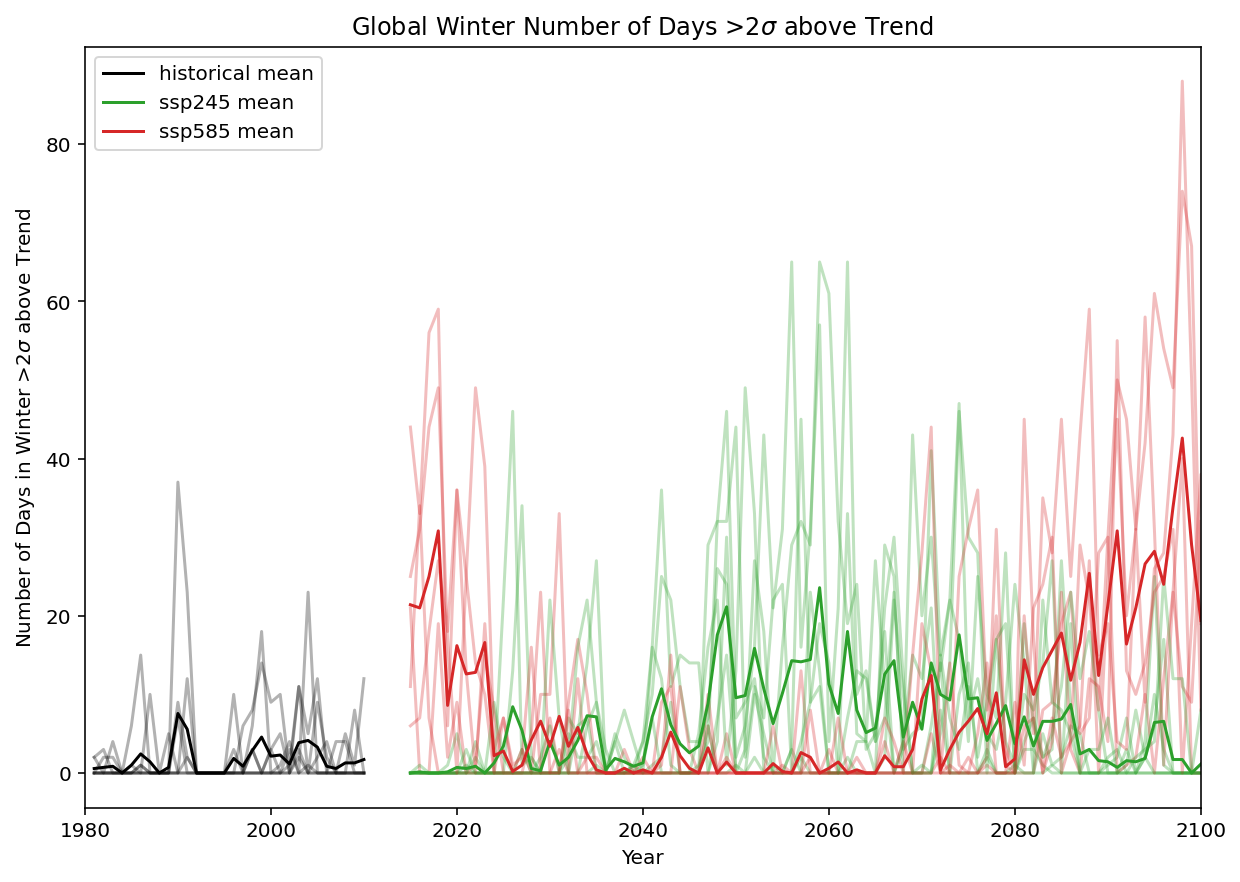

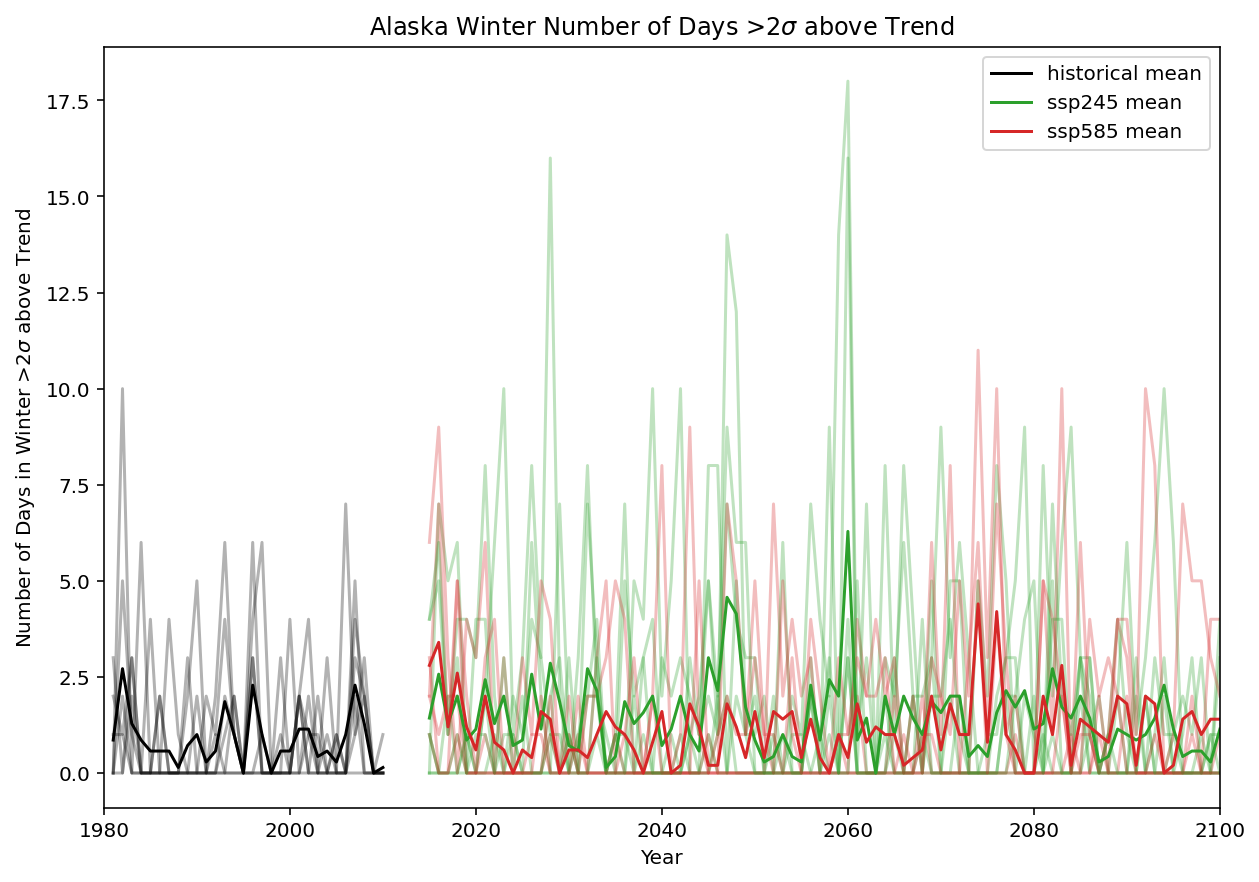

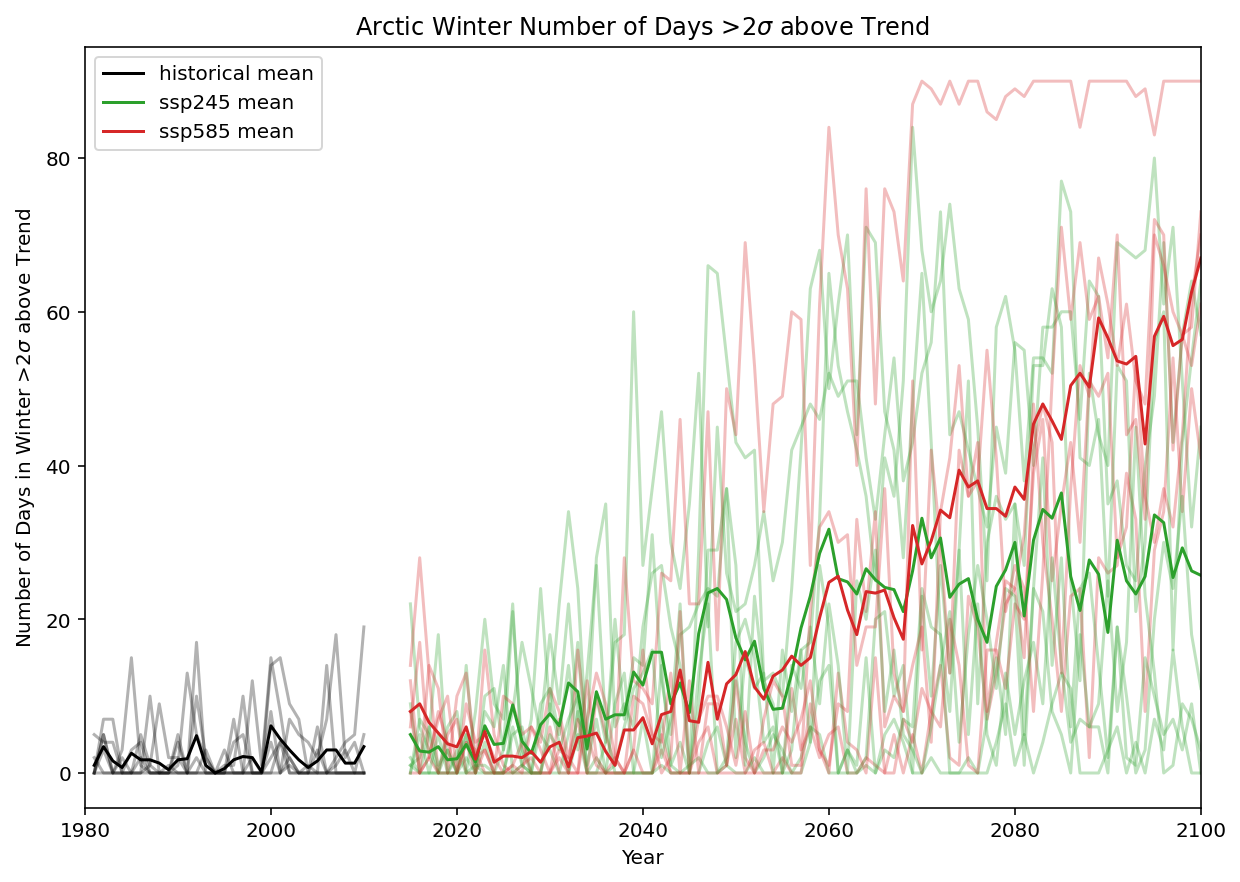

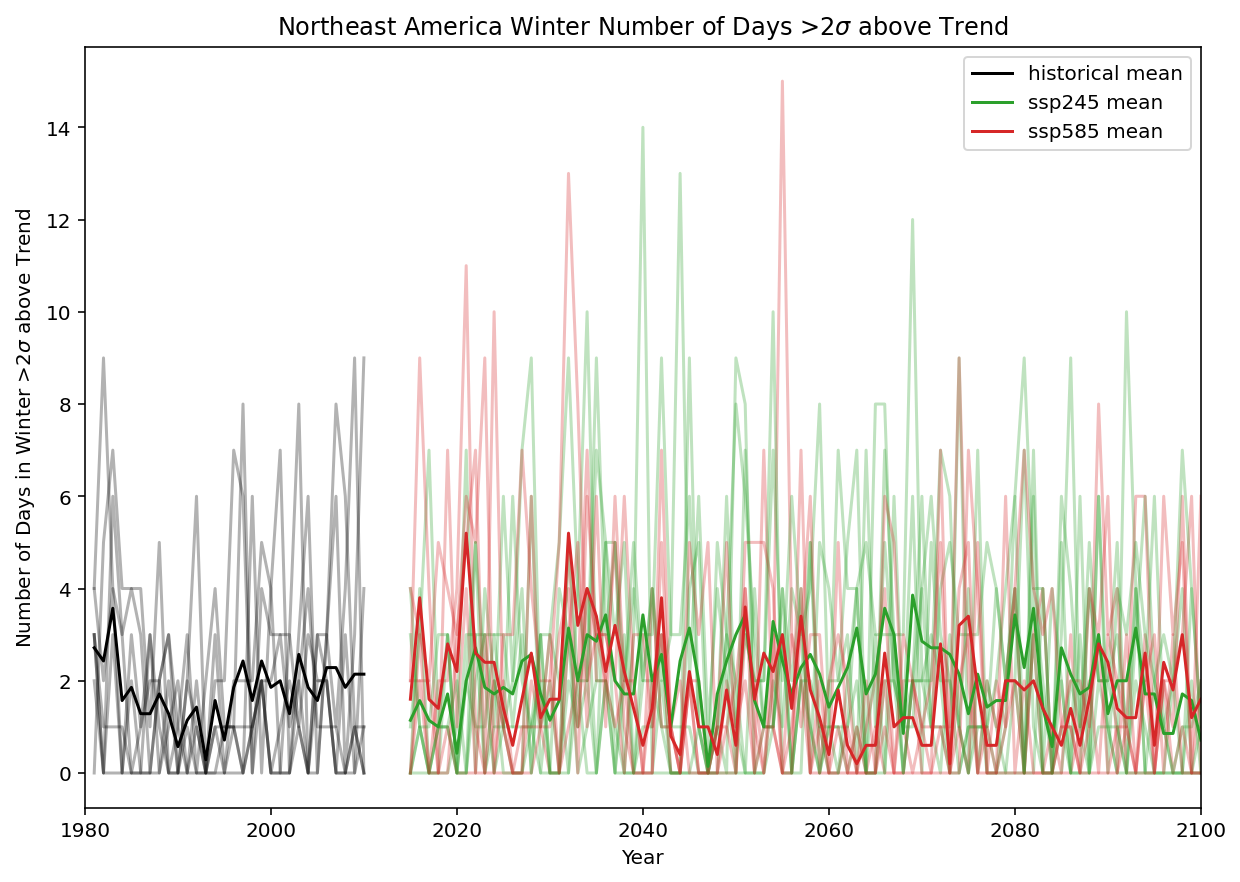

In [88]:
plot_winter_nsigs(notrend_winter_nsigs_hist,notrend_winter_nsigs_ssp245,notrend_winter_nsigs_ssp585,notrend_winter_hist_all,notrend_winter_ssp245_all,notrend_winter_ssp585_all,trend_removed=True)


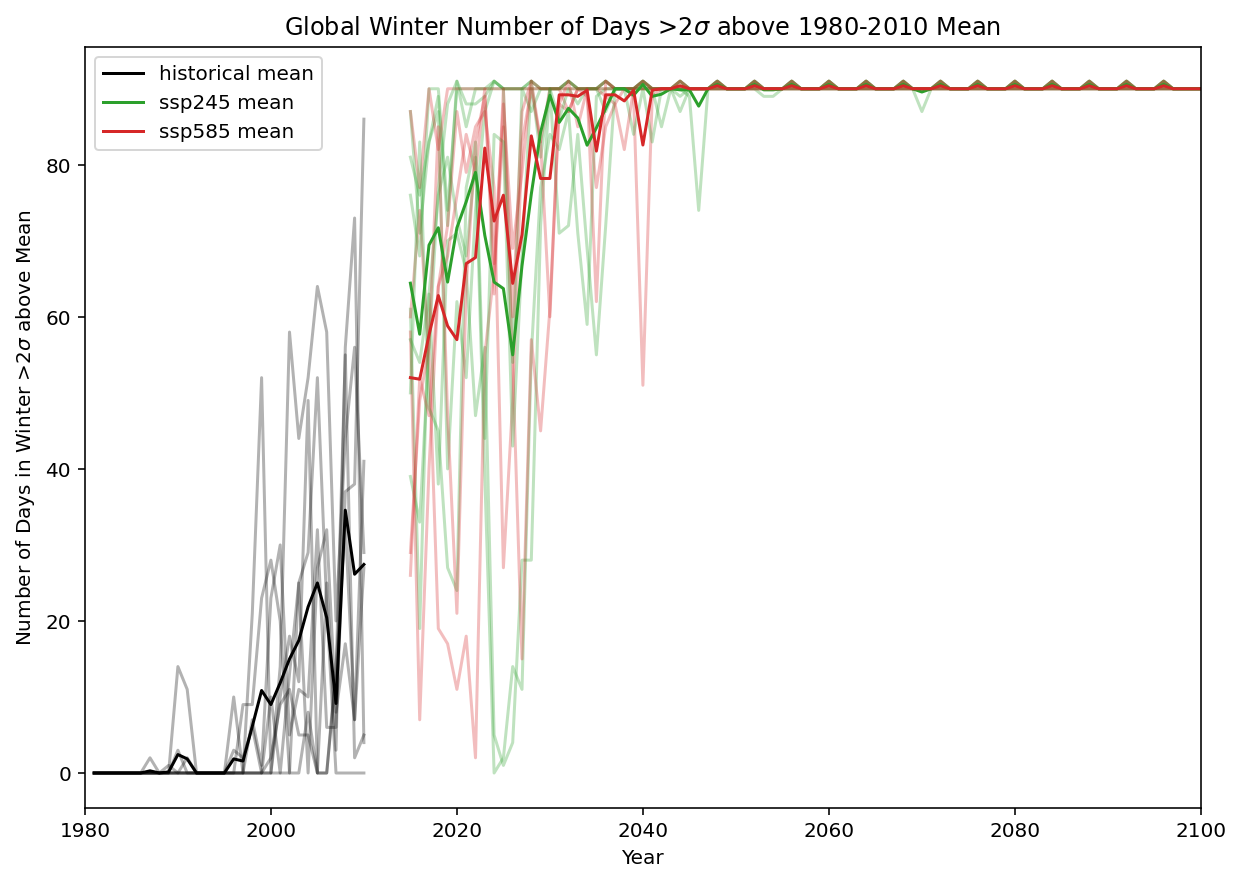

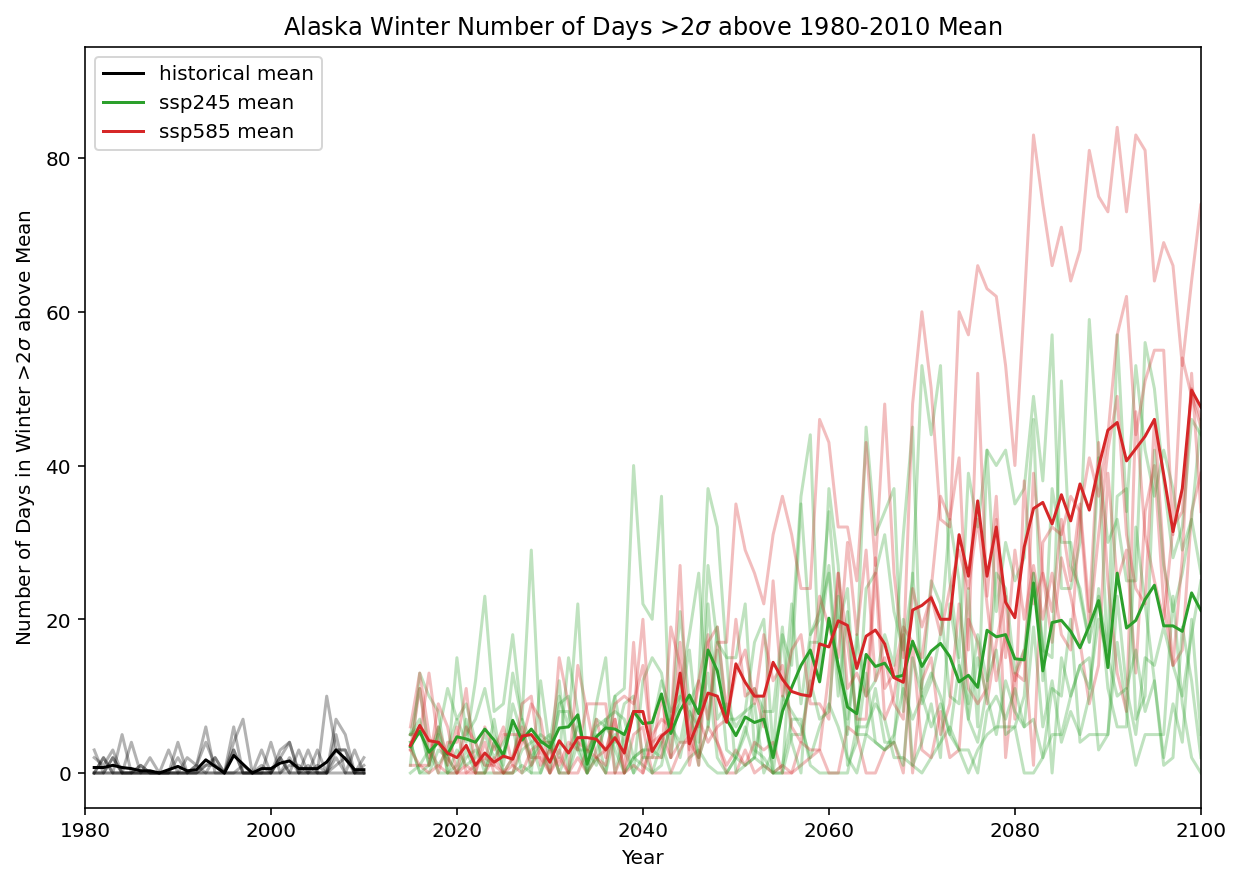

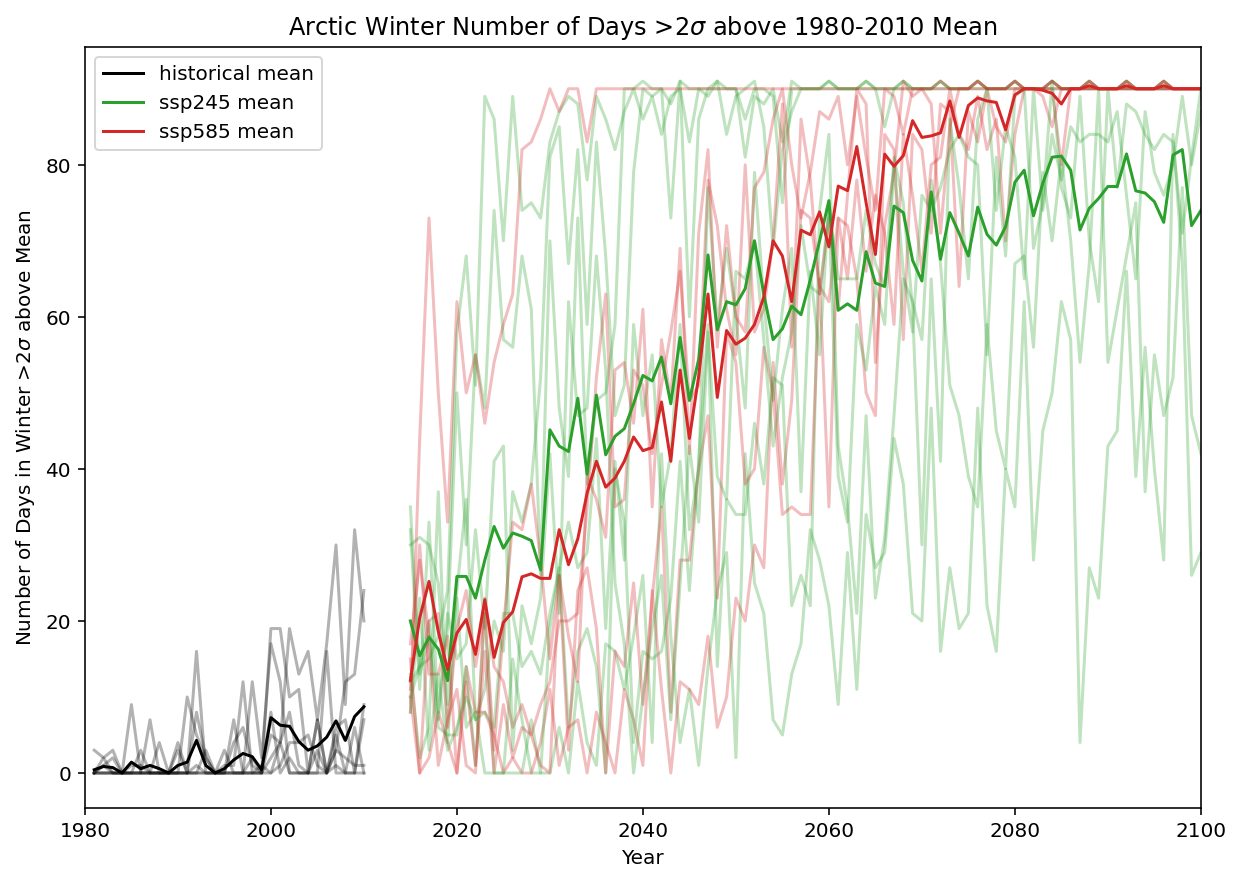

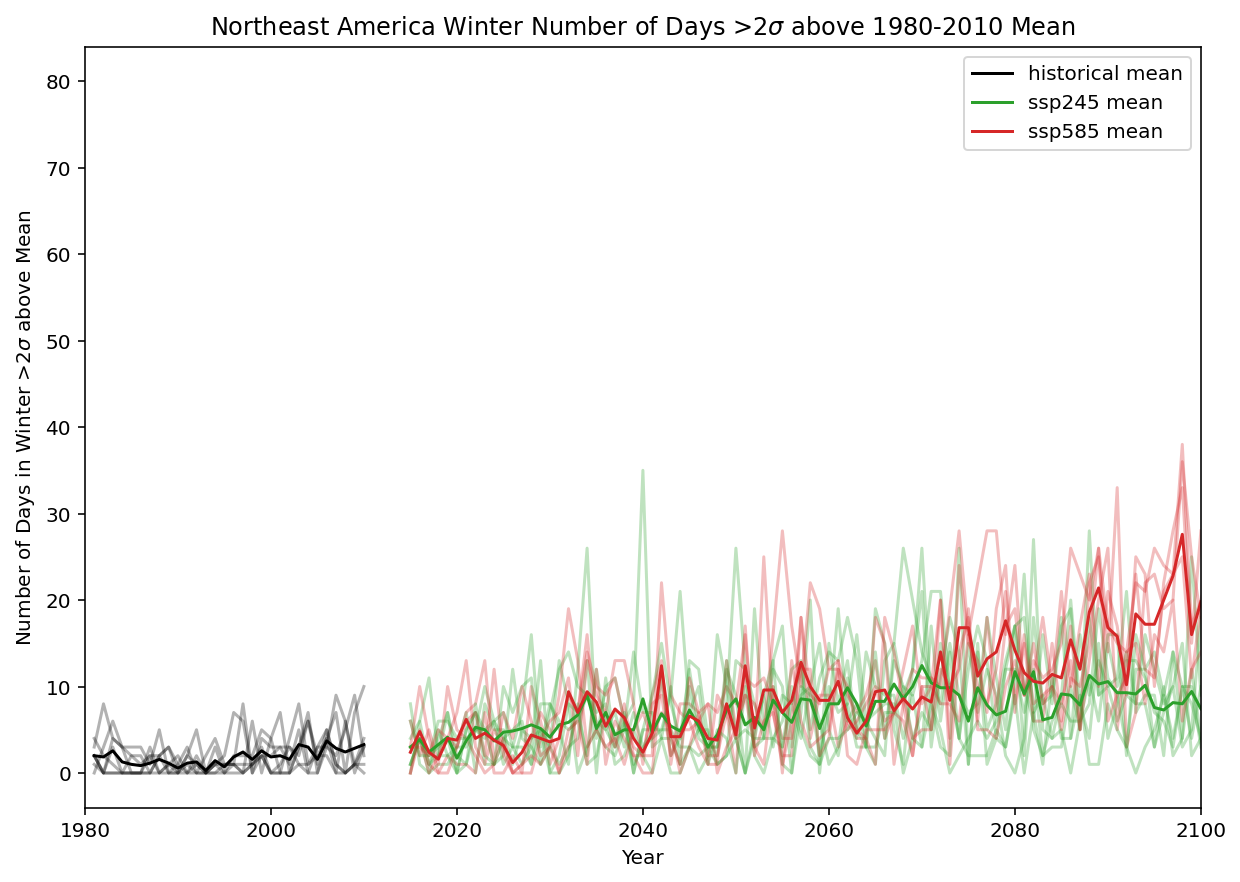

In [89]:
plot_winter_nsigs(winter_nsigs_hist,winter_nsigs_ssp245,winter_nsigs_ssp585,winter_hist_all,winter_ssp245_all,winter_ssp585_all,trend_removed=False)


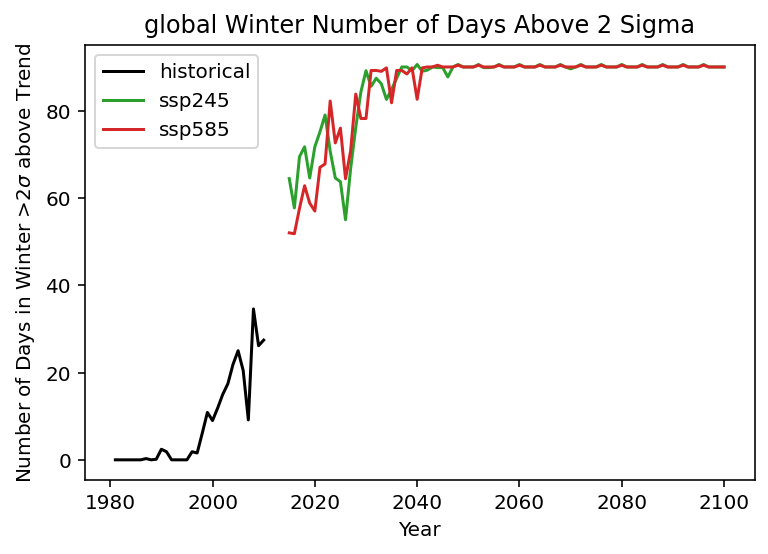

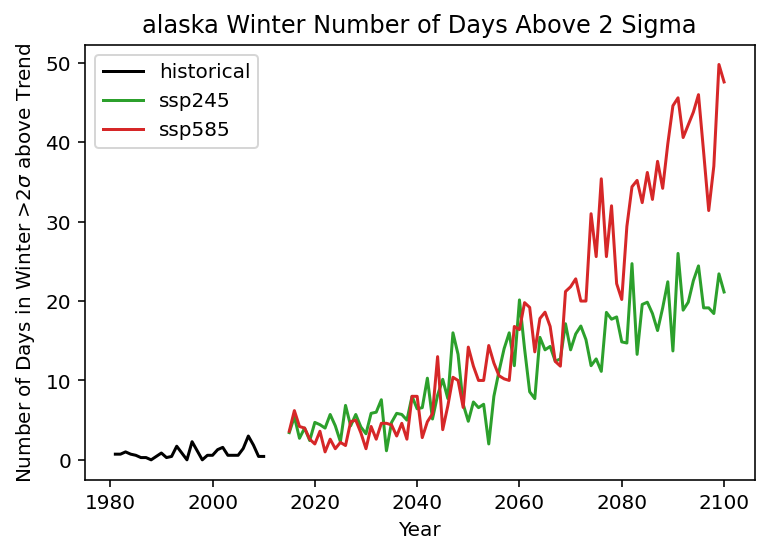

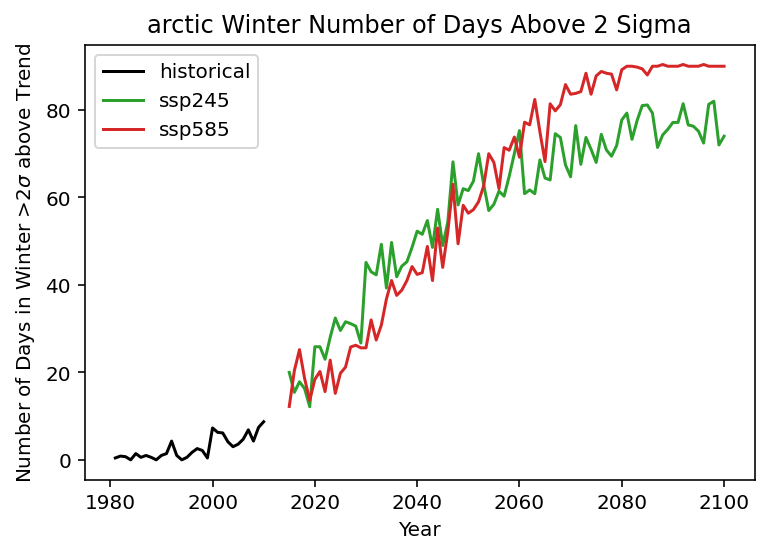

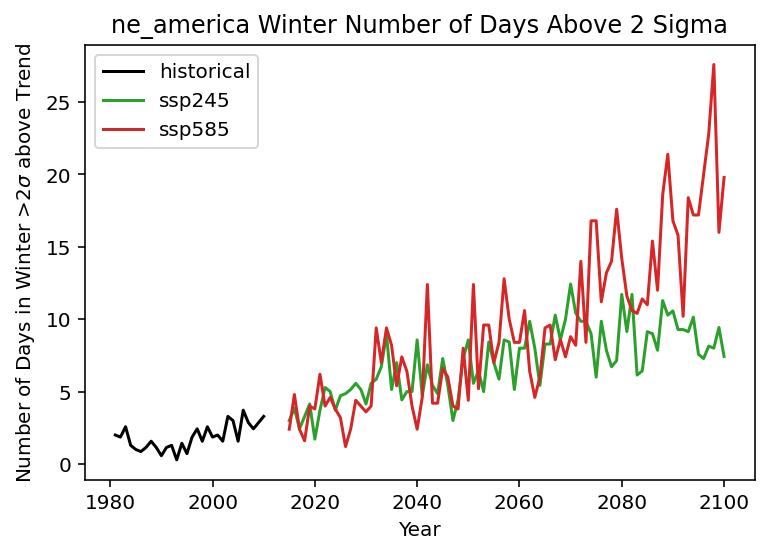

In [18]:
for r in regions:
    plt.figure(figsize=(6,4))
    plt.plot(notrend_winter_nsigs_hist['year'],notrend_winter_nsigs_hist[r+'_n2sig'],'k',label='historical')
    plt.plot(notrend_winter_nsigs_ssp245['year'],notrend_winter_nsigs_ssp245[r+'_n2sig'],color='tab:green',label='ssp245')
    plt.plot(notrend_winter_nsigs_ssp585['year'],notrend_winter_nsigs_ssp585[r+'_n2sig'],color='tab:red',label='ssp585')
    plt.xlabel('Year')
    plt.ylabel(r'Number of Days in Winter >2$\sigma$ above Trend')
    plt.legend()
    plt.title(r+' Winter Number of Days Above 2 Sigma')
    #plt.savefig('./figures/final_round_plots/n2sig_winter_modelsmean'+r+'.png')

# YEARDAY GRIDS & ANNUAL ANOMALIES

In [ ]:
def plot_yearday_grid(model,source_id,region):
    """
    model: time period ('historical')
    source_id: e.g. 'ACCESS-CM2'
    region: e.g. 'global'
    """
    data = scenarios_stdevs[model][source_id][region+'_anomaly_std']
    y0 = data['time.year'][0]
    nyears = int(data['time.year'][-1]-y0+1)
    grid = np.empty((nyears,365))
    years = []
    for year, ydata in data.groupby('time.year'):
        years.append(year)
        for day, ddata in ydata.groupby('dayofyear'):
            y_i = year-y0
            grid[y_i,day-1] = float(ddata[0])
    
    return grid, np.asarray(years)

In [ ]:
    plt.imshow(grid,aspect='auto',extent=[0,365,years[-1],years[0]],cmap='bwr')
    plt.colorbar()
    plt.title(region+' Temperature Anomaly in Standard Deviations, '+source_id_list[s])
    plt.xlabel('Day of Year')
    plt.ylabel('Year')
    plt.savefig('figures/models_stdev_plots/yearday_grid_plots/global_historical_'+source_id_list[s]+'.png')


In [ ]:
fig, axs = plt.subplots(1,7,figsize=(12,6))
neam_grids = []
neam_yearses = []
for s in range(len(source_id_list)):
    grid, years = plot_yearday_grid('historical',source_id_list[s],'global')
    neam_grids.append(grid)
    neam_yearses.append(years)
    #grid = grids[s]
    #years = yearses[s]
    im = axs[s].imshow(grid,aspect='auto',extent=[0,365,years[-1],years[0]],cmap='bwr')
    axs[s].set_title(source_id_list[s])
    axs[s].set_xlabel('Day of Year')
    if s==0:
        axs[s].set_ylabel('Year')
    else:
        axs[s].set_yticks([])
    #plot_yearday_grid(grid,years,'Global',s)
fig.suptitle('Global Temperature Anomaly in Standard Deviations, after trend removed')
fig.colorbar(im)
plt.savefig('figures/models_stdev_plots/yearday_grid_plots/global_historical_all_models_trend_removed.png')


In [ ]:
fig, axs = plt.subplots(1,7,figsize=(12,6))
#grids = []
#yearses = []
for s in range(len(source_id_list)):
    #grid, years = plot_yearday_grid('historical',source_id_list[s],'global')
    #grids.append(grid)
    #yearses.append(years)
    grid = grids[s]
    years = yearses[s]
    im = axs[s].imshow(grid,aspect='auto',extent=[0,365,years[-1],years[0]],cmap='bwr')
    axs[s].set_title(source_id_list[s])
    axs[s].set_xlabel('Day of Year')
    if s==0:
        axs[s].set_ylabel('Year')
    else:
        axs[s].set_yticks([])
    #plot_yearday_grid(grid,years,'Global',s)
fig.suptitle('Global Temperature Anomaly in Standard Deviations')
fig.colorbar(im)
plt.savefig('figures/models_stdev_plots/yearday_grid_plots/global_historical_all_models.png')


In [ ]:
def annual_mean_anomaly(model,source_id,region):
    data = scenarios_stdevs[model][source_id]
    years = []
    if model=='ssp585':
        data = data.sel(time=slice('2015-01-01', '2100-12-31'))
    regional_mean = []
    
    for year, ydata in data.groupby('time.year'):
        years.append(year)
        rmean = float(ydata[region+'_anomaly_std'].mean())
        regional_mean.append(rmean)
    
    return np.asarray(regional_mean), np.asarray(years)

In [ ]:
for s in source_id_list:
    #mean_array, years = annual_mean_anomaly('ssp585',s,'global')
    dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/'+s+'_ssp585_noleap.nc')
    print(dataset)

In [ ]:
for s in source_id_list:
    print(scenarios_stdevs['historical'][s]['global_anomaly_std'][:2])

In [ ]:
models=['historical','ssp245','ssp585']
#new_source_id_list = source_id_list.copy()
annual_mean_anomalies = {}
for m in models:
    region_dict={}
    for r in regions:
        init=True
        if m == 'ssp585':
            new_source_id_list = source_id_list[2:]
        else:
            new_source_id_list = source_id_list.copy()
        for s in new_source_id_list:
            mean_array,years = annual_mean_anomaly(m,s,r)
            #print(mean_array.shape)
            #print(mean_array[0])
            if init:
                region_array = np.vstack((years[None,:],mean_array[None,:]))
                print(region_array.shape)
                init=False
            else:
                region_array = np.vstack((region_array,mean_array))
                #print(region_array.shape)
        region_dict[r]=region_array
    annual_mean_anomalies[m]=region_dict
            
    

In [ ]:
annual_mean_anomalies['ssp585']['arctic'].shape

In [ ]:
plt.figure(figsize=(10,6))
hdata = annual_mean_anomalies['historical']['ne_america']
data585 = annual_mean_anomalies['ssp585']['ne_america']
data245 = annual_mean_anomalies['ssp245']['ne_america']
hmean = np.mean(hdata[1:,:],axis=0)
mean245 = np.mean(data245[1:,:],axis=0)
mean585 = np.mean(data585[1:,:],axis=0)
colors = [None,'tab:blue','tab:red','tab:orange','tab:green','tab:purple','tab:brown','tab:pink']
for i in range(1,8):
    plt.plot(hdata[0,:],hdata[i,:],color='tab:gray',alpha=0.3)
    plt.plot(data245[0,:],data245[i,:],color='tab:blue',alpha=0.3)
for i in range(1,6):
    plt.plot(data585[0,:],data585[i,:],color='tab:red',alpha=0.3)
plt.plot(hdata[0,:],hmean,color='k',label='Mean of Historical Models')
plt.plot(data245[0,:],mean245,color='tab:blue',label='Mean of ssp245 Models')
plt.plot(data585[0,:],mean585,color='tab:red',label='Mean of ssp585 Models')
plt.legend()
plt.title('Northeast America Annual Mean Temperature Anomaly')
plt.ylabel('Number of Standard Deviations from 1980-2010 Mean')
plt.xlabel('Year')
plt.savefig('figures/models_stdev_plots/annual_mean_anomalies/ne_america_historical+ssp245+ssp585_all_models.png')


In [ ]:
plt.figure(figsize=(8,6))
hdata = annual_mean_anomalies['historical']['global']
data245 = annual_mean_anomalies['ssp245']['global']
hmean = np.mean(hdata[1:,:],axis=0)
mean245 = np.mean(data245[1:,:],axis=0)
colors = [None,'tab:blue','tab:red','tab:orange','tab:green','tab:purple','tab:brown','tab:pink']
for i in range(1,8):
    plt.plot(hdata[0,:],hdata[i,:],color=colors[i],alpha=0.3,label=source_id_list[i-1])
    plt.plot(data245[0,:],data245[i,:],color=colors[i],alpha=0.3)
plt.plot(hdata[0,:],hmean,color='k',label='Mean of All Models')
plt.plot(data245[0,:],mean245,color='k')
plt.legend()
plt.title('Global Annual Mean Temperature Anomaly, Historical + ssp245')
plt.ylabel('Number of Standard Deviations from 1980-2010 Mean')
plt.xlabel('Years')
plt.savefig('figures/models_stdev_plots/annual_mean_anomalies/global_historical+ssp245_all_models.png')


In [ ]:
def plot_stdev_anomalies_over_time(region):
    plt.figure(figsize=(10,8))
    for m in models:
        #sum_stdevs = np.zeros((365))
        init=True
        for s in source_id_list:
            anomaly_std = scenarios_stdevs[m][s]
            if init:
                sum_anomalies = anomaly_std[region+'_anomaly_std']
                init=False
            #sum_stdevs += stdev[r+'_mean']
            anomaly_std = anomaly_std.sel(time=slice('1980-01-01', '2100-12-31'))
            #timeslice = np.asarray(histdata['time'])
            #time = [i[0].dayofyear for i in data_arrs[i]['time']]
            plt.plot(anomaly_std['time'],anomaly_std[region+'_anomaly_std'],alpha=0.3)
            #plt.plot(clims[i]['time'].dt.dayofyear,clims[i],label = regions[i]+' climatology mean')
            

    #sum_stdevs /= len(source_id_list)
    #plt.plot(np.arange(1,366),sum_stdevs,color='tab:red',label='Mean of 7 models')
    #plt.legend()
    #plt.xlim(1980,2100)
    plt.title(r+' Temperature Anomaly in Standard Deviations')
    plt.xlabel('Year')
    plt.ylabel(r+'Surface Temperature Anomaly [standard deviations]')
    #plt.savefig('./figures/models_stdev_plots/std_anomaly_alltime_allmodels_'+r+'.png')

In [ ]:
def plot_hist_stdev_anomalies(region):
    plt.figure(figsize=(10,8))
        #sum_stdevs = np.zeros((365))
    init=True
    for s in source_id_list:
        anomaly_std = scenarios_stdevs['historical'][s]
        if init:
            sum_anomalies = anomaly_std[region+'_anomaly_std']
            init=False
        #sum_stdevs += stdev[r+'_mean']
        #anomaly_std = anomaly_std.sel(time=slice('1980-01-01', '2100-12-31'))
        #timeslice = np.asarray(histdata['time'])
        #time = [i[0].dayofyear for i in data_arrs[i]['time']]
        plt.plot(anomaly_std['time'],anomaly_std[region+'_anomaly_std'],alpha=0.3,label=s)
        #plt.plot(clims[i]['time'].dt.dayofyear,clims[i],label = regions[i]+' climatology mean')
        

    #sum_stdevs /= len(source_id_list)
    #plt.plot(np.arange(1,366),sum_stdevs,color='tab:red',label='Mean of 7 models')
    plt.legend()
    #plt.xlim(1980,2100)
    plt.title(region+' Temperature Anomaly in Standard Deviations')
    plt.xlabel('Year')
    plt.ylabel(region+'Surface Temperature Anomaly [standard deviations]')
    #plt.savefig('figures_plane/hist_anomalies_timeseries/std_anomaly_historical_allmodels_'+region+'.png')

In [ ]:
for r in regions:
    plot_hist_stdev_anomalies(r)

In [ ]:
for s in range(len(source_id_list)):
    fig, axs = plt.subplots(4, 3,figsize=(15,15))
    months = ['','January','February','March','April','May','June','July','August','September','October','November','December']
    months_heat = nsig_historical_all_sources[s]
    #plot the number of days above 2sigma by region and month
    axs1=[0,0,0,0,1,1,1,2,2,2,3,3,3]
    axs2=[0,0,1,2,0,1,2,0,1,2,0,1,2]
    for i in range(1,13):
        n_2sig = months_heat[i]
        axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['global_n2sig'],label='Global')
        axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['alaska_n2sig'],label='Alaska')
        axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['arctic_n2sig'],label='Arctic')
        axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['ne_america_n2sig'],label='NE America')
        axs[axs1[i], axs2[i]].set_title(months[i])
        #axs[axs1[i], axs2[i]].xlabel('Year')
        axs[axs1[i], axs2[i]].legend()
        #axs[axs1[i], axs2[i]].ylabel('# Days 2 Standard Deviations Above Mean')

    fig.suptitle('# Days With Temperature Anomaly 2 stdev Above Mean by Month, '+source_id_list[s])
    for ax in axs.flat:
        ax.set(ylabel='# Days 2sigma Above Mean')
        
    plt.savefig('figures/figures_plane/hist_n2sig_individual_sources/n_2sig_heat_monthly_historical'+source_id_list[s]+'.png')

In [ ]:
fig, axs = plt.subplots(4, 3,figsize=(15,15))
months = ['','January','February','March','April','May','June','July','August','September','October','November','December']
#plot the number of days above 2sigma by region and month
axs1=[0,0,0,0,1,1,1,2,2,2,3,3,3]
axs2=[0,0,1,2,0,1,2,0,1,2,0,1,2]
for i in range(1,13):
    n_2sig = historical_sum_nsigs_dict[i]
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['global_n2sig'],color='tab:blue',label='Global')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['alaska_n2sig'],color='tab:orange',label='Alaska')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['arctic_n2sig'],color='tab:green',label='Arctic')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['ne_america_n2sig'],color='tab:red',label='NE America')
    n_2sig = ssp245_sum_nsigs_dict[i]
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['global_n2sig'],color='tab:blue')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['alaska_n2sig'],color='tab:orange')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['arctic_n2sig'],color='tab:green')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['ne_america_n2sig'],color='tab:red')
    axs[axs1[i], axs2[i]].set_title(months[i])
    #axs[axs1[i], axs2[i]].xlabel('Year')
    axs[axs1[i], axs2[i]].legend()
    #axs[axs1[i], axs2[i]].ylabel('# Days 2 Standard Deviations Above Mean')

fig.suptitle('# Days With Temperature Anomaly 2 stdev Above Trend by Month, historical + ssp245')
for ax in axs.flat:
    ax.set(ylabel='# Days 2sigma Above Trend')
    
plt.savefig('figures/figures_plane/n_2sig_monthly_heat_historical+ssp245_allsource_mean_trend_removed.png')

In [ ]:
fig, axs = plt.subplots(4, 3,figsize=(15,15))
months = ['','January','February','March','April','May','June','July','August','September','October','November','December']
#plot the number of days above 2sigma by region and month
axs1=[0,0,0,0,1,1,1,2,2,2,3,3,3]
axs2=[0,0,1,2,0,1,2,0,1,2,0,1,2]
for i in range(1,13):
    n_2sig = historical_sum_nsigs_dict[i]
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['global_n2sig'],color='tab:blue',label='Global')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['alaska_n2sig'],color='tab:orange',label='Alaska')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['arctic_n2sig'],color='tab:green',label='Arctic')
    axs[axs1[i], axs2[i]].plot(n_2sig['year'],n_2sig['ne_america_n2sig'],color='tab:red',label='NE America')
    axs[axs1[i], axs2[i]].set_title(months[i])
    #axs[axs1[i], axs2[i]].xlabel('Year')
    axs[axs1[i], axs2[i]].legend()
    #axs[axs1[i], axs2[i]].ylabel('# Days 2 Standard Deviations Above Mean')

fig.suptitle('# Days With Temperature Anomaly 2 stdev Above Mean by Month, historical + ssp245')
for ax in axs.flat:
    ax.set(ylabel='# Days 2sigma Above Mean')
    
plt.savefig('figures_plane/n_2sig_monthly_heat_historical_allsource_mean.png')